In [1]:
import pandas as pd
import numpy as np

# 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import random

# 모델
from lightgbm import LGBMClassifier

# 시각화 툴
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

pd.options.mode.chained_assignment = None

In [2]:
x_train_path = './content/train.csv'
y_train_path = './content/train_label.csv'
x_test_path = './content/test.csv'

x_train = pd.read_csv(x_train_path)
x_test = pd.read_csv(x_test_path)
y_train = pd.read_csv(y_train_path)

# 이메일당 라벨 부여하는 코드
print(len(x_train.iloc[:, 1]))
for i in range(0, len(x_train.iloc[:, 1])):
    for j in range(0, len(y_train.iloc[:, 1])):
        if x_train.iloc[i, 0] == y_train.iloc[j, 0]:
            x_train.loc[i, 'diag_NM'] = y_train.iloc[j, 1]

9327


In [3]:
x_train_org = x_train
x_train = x_train_org

In [4]:
x_train.head(5)

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),diag_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN


In [5]:

# 불필요한 컬럼 제거 작업
drop = ['EMAIL', 'summary_date', 'activity_class_5min','activity_met_1min', 'sleep_hr_5min', 'sleep_hypnogram_5min',
        'sleep_is_longest', 'sleep_rmssd_5min', 'timezone', 'sleep_total','sleep_temperature_trend_deviation', 
        'CONVERT(activity_class_5min USING utf8)','CONVERT(activity_met_1min USING utf8)', 'CONVERT(sleep_hr_5min USING utf8)',
        'CONVERT(sleep_hypnogram_5min USING utf8)','CONVERT(sleep_rmssd_5min USING utf8)']
x_train = x_train.drop(columns = drop)
test_email = x_test['EMAIL']
x_test = x_test.drop(columns = drop)

In [6]:
x_train.columns

Index(['activity_average_met', 'activity_cal_active', 'activity_cal_total',
       'activity_daily_movement', 'activity_high', 'activity_inactive',
       'activity_inactivity_alerts', 'activity_low', 'activity_medium',
       'activity_met_min_high', 'activity_met_min_inactive',
       'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear',
       'activity_rest', 'activity_score', 'activity_score_meet_daily_targets',
       'activity_score_move_every_hour', 'activity_score_recovery_time',
       'activity_score_stay_active', 'activity_score_training_frequency',
       'activity_score_training_volume', 'activity_steps', 'activity_total',
       'sleep_awake', 'sleep_breath_average', 'sleep_deep', 'sleep_duration',
       'sleep_efficiency', 'sleep_hr_average', 'sleep_hr_lowest',
       'sleep_light', 'sleep_midpoint_at_delta', 'sleep_midpoint_time',
       'sleep_onset_latency', 'sleep_period_id', 'sleep_rem', 'sleep_restless',
       'sleep_rmssd', 'sleep_score', 'sle

In [7]:
x_train_org.columns

Index(['EMAIL', 'summary_date', 'activity_average_met', 'activity_cal_active',
       'activity_cal_total', 'activity_class_5min', 'activity_daily_movement',
       'activity_high', 'activity_inactive', 'activity_inactivity_alerts',
       'activity_low', 'activity_medium', 'activity_met_1min',
       'activity_met_min_high', 'activity_met_min_inactive',
       'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear',
       'activity_rest', 'activity_score', 'activity_score_meet_daily_targets',
       'activity_score_move_every_hour', 'activity_score_recovery_time',
       'activity_score_stay_active', 'activity_score_training_frequency',
       'activity_score_training_volume', 'activity_steps', 'activity_total',
       'sleep_awake', 'sleep_breath_average', 'sleep_deep', 'sleep_duration',
       'sleep_efficiency', 'sleep_hr_5min', 'sleep_hr_average',
       'sleep_hr_lowest', 'sleep_hypnogram_5min', 'sleep_is_longest',
       'sleep_light', 'sleep_midpoint_at_delta', 

In [8]:
#activity_score_meet_daily_target
#sleep_period
#activity_inactiviy_alert
#activity_score_recovery_time
#=>위 추가 drop by feature selection


x_train = x_train.drop(columns = ['activity_average_met', 'activity_cal_active', 'activity_cal_total','activity_steps', 'activity_score',
                                    'activity_score_move_every_hour', 'activity_daily_movement','activity_met_min_high',
                                    'activity_score_stay_active', 'activity_total', 'activity_met_min_low','activity_medium',
                                    'activity_score_training_frequency','activity_steps', 'activity_score',
                                    'activity_score_training_volume','sleep_efficiency','sleep_duration','sleep_hr_lowest',
                                    'sleep_midpoint_time','sleep_awake','sleep_deep','sleep_rem','sleep_restless','sleep_temperature_delta',
                                    'sleep_score_total','sleep_score','activity_score_meet_daily_targets','sleep_period_id','activity_inactivity_alerts','activity_score_recovery_time'])
x_test = x_test.drop(columns = ['activity_average_met', 'activity_cal_active', 'activity_cal_total','activity_steps', 'activity_score',
                                    'activity_score_move_every_hour', 'activity_daily_movement','activity_met_min_high',
                                    'activity_score_stay_active', 'activity_total', 'activity_met_min_low','activity_medium',
                                    'activity_score_training_frequency','activity_steps', 'activity_score',
                                    'activity_score_training_volume','sleep_efficiency','sleep_duration','sleep_hr_lowest',
                                    'sleep_midpoint_time','sleep_awake','sleep_deep','sleep_rem','sleep_restless','sleep_temperature_delta',
                                    'sleep_score_total','sleep_score','activity_score_meet_daily_targets','sleep_period_id','activity_inactivity_alerts','activity_score_recovery_time'])

In [9]:
x_train.head(5)

,activity_high,activity_inactive,activity_low,activity_met_min_inactive,activity_met_min_medium,activity_non_wear,activity_rest,sleep_breath_average,sleep_hr_average,sleep_light,...,sleep_onset_latency,sleep_rmssd,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_temperature_deviation,diag_NM
0,0,417,545,7,160,32,399,16.500,70.53,15030,...,960,20,100,41,50,27,97,66,-0.12,CN
1,0,473,392,8,24,29,538,17.375,68.01,12210,...,690,19,100,49,43,46,91,35,-0.32,CN
2,0,586,362,14,76,9,459,17.000,64.89,15780,...,1140,26,100,56,47,34,89,41,0.07,CN
3,0,176,34,1,3,19,1210,17.250,63.70,16350,...,1170,30,100,35,40,44,86,29,-0.41,CN
4,0,646,377,15,19,19,392,17.250,67.07,14010,...,3360,23,100,64,55,39,14,54,-0.27,CN


In [10]:
enc = LabelEncoder()
diag = x_train['diag_NM']
enc.fit(diag)
diag = enc.transform(diag)

In [11]:
x_train.head(5)

,activity_high,activity_inactive,activity_low,activity_met_min_inactive,activity_met_min_medium,activity_non_wear,activity_rest,sleep_breath_average,sleep_hr_average,sleep_light,...,sleep_onset_latency,sleep_rmssd,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_temperature_deviation,diag_NM
0,0,417,545,7,160,32,399,16.500,70.53,15030,...,960,20,100,41,50,27,97,66,-0.12,CN
1,0,473,392,8,24,29,538,17.375,68.01,12210,...,690,19,100,49,43,46,91,35,-0.32,CN
2,0,586,362,14,76,9,459,17.000,64.89,15780,...,1140,26,100,56,47,34,89,41,0.07,CN
3,0,176,34,1,3,19,1210,17.250,63.70,16350,...,1170,30,100,35,40,44,86,29,-0.41,CN
4,0,646,377,15,19,19,392,17.250,67.07,14010,...,3360,23,100,64,55,39,14,54,-0.27,CN


In [12]:
stack = 0
for i in x_train['diag_NM']:
    if i != 'CN':
        stack += 1
print(stack)

3358


In [13]:
from pycaret.classification import *
from sklearn.metrics import log_loss

In [14]:
exp_mclf101 = setup(data=x_train, target='diag_NM', session_id=123, use_gpu=True)

,Description,Value
0,session_id,123
1,Target,diag_NM
2,Target Type,Multiclass
3,Label Encoded,"CN: 0, Dem: 1, MCI: 2"
4,Original Data,"(9327, 21)"
5,Missing Values,False
6,Numeric Features,20
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [15]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8404,0.9201,0.7649,0.8412,0.8352,0.6622,0.6707,4.9760
xgboost,Extreme Gradient Boosting,0.8197,0.9014,0.7357,0.8196,0.8131,0.6161,0.6253,3.4970
lightgbm,Light Gradient Boosting Machine,0.8059,0.8937,0.7110,0.8081,0.7957,0.5776,0.5942,0.5050
rf,Random Forest Classifier,0.7805,0.8863,0.6116,0.8011,0.7562,0.4907,0.5383,1.0090
et,Extra Trees Classifier,0.7719,0.8920,0.5918,0.8044,0.7417,0.4595,0.5229,1.0310
gbc,Gradient Boosting Classifier,0.7327,0.8150,0.5791,0.7382,0.7002,0.3771,0.4215,4.3480
qda,Quadratic Discriminant Analysis,0.6838,0.7547,0.6115,0.6835,0.6826,0.3690,0.3698,0.0210
dt,Decision Tree Classifier,0.6628,0.6677,0.5670,0.6665,0.6641,0.3340,0.3344,0.0800
lr,Logistic Regression,0.6469,0.6537,0.4113,0.6013,0.5541,0.0918,0.1428,1.7530
lda,Linear Discriminant Analysis,0.6426,0.6739,0.4395,0.5956,0.5720,0.1246,0.1592,0.0320


In [16]:
catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8315,0.9210,0.7402,0.8298,0.8271,0.6455,0.6505
1,0.8453,0.9318,0.7638,0.8449,0.8413,0.6743,0.6801
2,0.8346,0.9182,0.7370,0.8382,0.8279,0.6444,0.6566
3,0.8438,0.9177,0.7881,0.8428,0.8399,0.6738,0.6791
4,0.8300,0.9155,0.7478,0.8291,0.8259,0.6439,0.6485
5,0.8331,0.9187,0.7646,0.8328,0.8298,0.6517,0.6556
6,0.8423,0.9092,0.7759,0.8504,0.8326,0.6571,0.6789
7,0.8469,0.9278,0.7693,0.8468,0.8421,0.6766,0.6843
8,0.8405,0.9151,0.7667,0.8398,0.8352,0.6617,0.6697
9,0.8558,0.9256,0.7960,0.8577,0.8505,0.6933,0.7035


In [17]:
x_train.head(5)

,activity_high,activity_inactive,activity_low,activity_met_min_inactive,activity_met_min_medium,activity_non_wear,activity_rest,sleep_breath_average,sleep_hr_average,sleep_light,...,sleep_onset_latency,sleep_rmssd,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_temperature_deviation,diag_NM
0,0,417,545,7,160,32,399,16.500,70.53,15030,...,960,20,100,41,50,27,97,66,-0.12,CN
1,0,473,392,8,24,29,538,17.375,68.01,12210,...,690,19,100,49,43,46,91,35,-0.32,CN
2,0,586,362,14,76,9,459,17.000,64.89,15780,...,1140,26,100,56,47,34,89,41,0.07,CN
3,0,176,34,1,3,19,1210,17.250,63.70,16350,...,1170,30,100,35,40,44,86,29,-0.41,CN
4,0,646,377,15,19,19,392,17.250,67.07,14010,...,3360,23,100,64,55,39,14,54,-0.27,CN


In [18]:
from pycaret.utils import version
version()

'2.3.1'

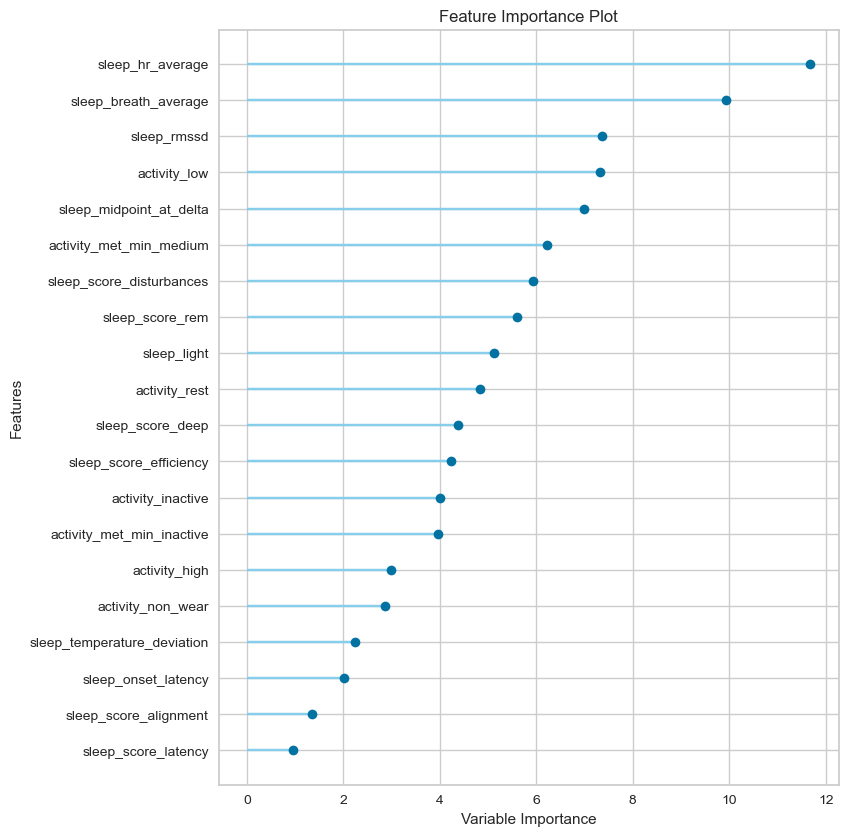

In [19]:
plot_model(catboost, plot='feature_all')

In [20]:
import pandas as pd
feature_importances = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value': abs(
    catboost.feature_importances_)}).sort_values(by='Value', ascending=False)

In [21]:
feature_importances.head(20)

,Feature,Value
8,sleep_hr_average,11.684102
7,sleep_breath_average,9.923157
12,sleep_rmssd,7.370674
2,activity_low,7.310969
10,sleep_midpoint_at_delta,6.982852
4,activity_met_min_medium,6.229677
15,sleep_score_disturbances,5.937472
18,sleep_score_rem,5.606661
9,sleep_light,5.124442
6,activity_rest,4.826922


In [22]:
#feature_importances.to_csv('./content/feature_importances.csv', index=False)

In [23]:
test_csv = predict_model(catboost, x_test)

In [24]:
test_csv

,activity_high,activity_inactive,activity_low,activity_met_min_inactive,activity_met_min_medium,activity_non_wear,activity_rest,sleep_breath_average,sleep_hr_average,sleep_light,...,sleep_rmssd,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_temperature_deviation,Label,Score
0,0.0,588.0,0.0,0.0,29.0,41.0,502.0,15.998712,69.541010,11047.0,...,29.0,100.0,41.0,55.0,75.0,94.0,55.0,-0.346215,CN,0.9846
1,0.0,544.0,309.0,6.0,0.0,163.0,601.0,13.051701,60.901762,6212.0,...,10.0,99.0,70.0,69.0,93.0,84.0,73.0,0.019516,CN,0.9889
2,2.0,559.0,236.0,12.0,154.0,14.0,439.0,13.045471,43.534256,13934.0,...,33.0,88.0,89.0,49.0,78.0,99.0,36.0,0.022043,CN,0.9557
3,0.0,671.0,212.0,6.0,0.0,171.0,709.0,16.474520,64.184992,12222.0,...,19.0,83.0,95.0,74.0,88.0,51.0,100.0,0.013762,CN,0.8912
4,0.0,767.0,479.0,6.0,0.0,0.0,506.0,16.299909,60.320205,7692.0,...,43.0,100.0,9.0,39.0,34.0,96.0,39.0,-0.110565,CN,0.9694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29087,20.0,513.0,420.0,7.0,238.0,115.0,566.0,13.792295,65.301817,7153.0,...,10.0,100.0,78.0,78.0,73.0,54.0,25.0,0.063381,CN,0.6291
29088,6.0,853.0,217.0,9.0,397.0,0.0,506.0,14.549449,61.628376,11099.0,...,29.0,72.0,100.0,62.0,20.0,99.0,70.0,-0.257062,CN,0.9940
29089,12.0,705.0,152.0,1.0,299.0,0.0,360.0,12.388876,59.341031,15752.0,...,14.0,99.0,71.0,49.0,30.0,82.0,50.0,0.487908,CN,0.8482
29090,6.0,648.0,247.0,8.0,295.0,0.0,504.0,14.147157,42.814743,7121.0,...,10.0,91.0,100.0,94.0,98.0,80.0,54.0,0.298931,CN,0.9694


In [25]:
sub = pd.read_csv('./content/sample_submission.csv')

In [26]:
sub['DIAG_NM'][0]

'CN'

In [27]:
len(sub['ID'])

471

In [28]:
test_csv = pd.concat([test_email,test_csv],axis=1)

In [29]:
test_csv

,EMAIL,activity_high,activity_inactive,activity_low,activity_met_min_inactive,activity_met_min_medium,activity_non_wear,activity_rest,sleep_breath_average,sleep_hr_average,...,sleep_rmssd,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_temperature_deviation,Label,Score
0,nia+075@rowan.kr,0.0,588.0,0.0,0.0,29.0,41.0,502.0,15.998712,69.541010,...,29.0,100.0,41.0,55.0,75.0,94.0,55.0,-0.346215,CN,0.9846
1,nia+075@rowan.kr,0.0,544.0,309.0,6.0,0.0,163.0,601.0,13.051701,60.901762,...,10.0,99.0,70.0,69.0,93.0,84.0,73.0,0.019516,CN,0.9889
2,nia+075@rowan.kr,2.0,559.0,236.0,12.0,154.0,14.0,439.0,13.045471,43.534256,...,33.0,88.0,89.0,49.0,78.0,99.0,36.0,0.022043,CN,0.9557
3,nia+075@rowan.kr,0.0,671.0,212.0,6.0,0.0,171.0,709.0,16.474520,64.184992,...,19.0,83.0,95.0,74.0,88.0,51.0,100.0,0.013762,CN,0.8912
4,nia+075@rowan.kr,0.0,767.0,479.0,6.0,0.0,0.0,506.0,16.299909,60.320205,...,43.0,100.0,9.0,39.0,34.0,96.0,39.0,-0.110565,CN,0.9694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29087,nia+513@rowan.kr,20.0,513.0,420.0,7.0,238.0,115.0,566.0,13.792295,65.301817,...,10.0,100.0,78.0,78.0,73.0,54.0,25.0,0.063381,CN,0.6291
29088,nia+513@rowan.kr,6.0,853.0,217.0,9.0,397.0,0.0,506.0,14.549449,61.628376,...,29.0,72.0,100.0,62.0,20.0,99.0,70.0,-0.257062,CN,0.9940
29089,nia+513@rowan.kr,12.0,705.0,152.0,1.0,299.0,0.0,360.0,12.388876,59.341031,...,14.0,99.0,71.0,49.0,30.0,82.0,50.0,0.487908,CN,0.8482
29090,nia+513@rowan.kr,6.0,648.0,247.0,8.0,295.0,0.0,504.0,14.147157,42.814743,...,10.0,91.0,100.0,94.0,98.0,80.0,54.0,0.298931,CN,0.9694


In [30]:

test_email

0        nia+075@rowan.kr
1        nia+075@rowan.kr
2        nia+075@rowan.kr
3        nia+075@rowan.kr
4        nia+075@rowan.kr
               ...       
29087    nia+513@rowan.kr
29088    nia+513@rowan.kr
29089    nia+513@rowan.kr
29090    nia+513@rowan.kr
29091    nia+513@rowan.kr
Name: EMAIL, Length: 29092, dtype: object

In [31]:

test_csv['EMAIL'][0]

'nia+075@rowan.kr'

In [32]:
sub['DIAG_NM'] = 0

In [ ]:

for j in range(0,len(sub['ID'])):
    for i in range(0,len(test_email)):
        if test_email[i] == sub['ID'][j]:
            sub['DIAG_NM'][j] = test_csv['Label'][i]
            continue

In [ ]:

sub

In [ ]:
# 검증용
"""
stack = 0
for i in sub['DIAG_NM']:
    if i == 'CN':
        stack+=1
print(stack)

In [ ]:
sub.to_csv('./content/predict3.csv', index=False)